In [31]:
%%capture
%matplotlib inline
#Block output of installs and determine plot output 

#Install and upgrade relevant libraries
!pip install seaborn yahooquery PyPDF2 --upgrade                                            

#Import all relevant libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import Ticker
import numpy as np
from PyPDF2 import PdfReader
import os
from datetime import date as dt
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
import re

#Block warnings and set displayed dataframe settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)                                                        
pd.set_option('max_colwidth', 1000)                                                            

In [59]:
#FUNCTIONS

#Function for dual axis linegraph
#Input parameters are dataframe, seaborn style, x axis, left y axis, colour for left y value, right y axis, colour for right y value
def dual_lines(df,style,x,y1,colour1,y2,colour2,title):

    #Set figure size and style
    plt.figure(figsize=(10,6))
    sns.set_style(style)

    #Define artist layer for left y axis and places legend in top right
    ax1 = sns.lineplot(data=df,x=x,y=y1,label=y1,color=colour1)
    plt.legend(loc='upper right',bbox_to_anchor=(0.866,0.98),alignment='left')

    #Define second plot on the same figure as a lineplot for right y axis and sharing the same x axis
    ax2 = plt.twinx()
    ax2 = sns.lineplot(data=df,x=x,y=y2,label=y2,color=colour2)

    #Legend is adjusted to be just under the first legend
    plt.legend(loc='upper right',bbox_to_anchor=(0.9,0.925),alignment='left')

    #Set x ticks to be evenly spaced values across all available x values
    ax2.set_xticks(df[x].tolist()[0::12] + [df[x].tolist()[-1]])

    #Adjusts labels for all axes
    ax1.set_xlabel(x,fontweight='bold')
    ax1.set_ylabel(y1,fontweight='bold')
    ax2.set_ylabel(y2,fontweight='bold',rotation=270,labelpad=13)

    #Set plain style for y axes rounding and sets a title
    ax1.ticklabel_format(axis='y',style='plain')
    ax2.ticklabel_format(axis='y',style='plain')
    plt.title(title,fontweight='demibold')
    
    return plt.show()

#Data wrangling function for Newswhip data
def wrangle(df):

    #Drops columns
    df.drop(['Link','Authors','Pinterest','LinkedIn','Twitter Influencer Shares','Total Facebook','Likes','Shares','Comments'],axis=1,inplace=True)

    #Converts published column to datetime format and converts article title to lowercase
    df['Published'] = df['Published'].apply(lambda x: x[0:4] + '-' + x[5:7])
    df['Headline'] = df['Headline'].str.lower()
    
    #Renames and reorders columns
    df.rename(columns={'Published':'Date','Group':'Keyword','Headline':'Title','Total Interactions':'Interactions'},inplace=True)
    df = df.reindex(columns=['Date','Keyword','Title','Website','Interactions'])

    return df

#Sustainability keyword categorizing function
def kw_categorize(keyword):
    if keyword in ['Climate Change','Global Warming','Greenhouse gas','Pollution']:
        return 'Climate'
    elif keyword == 'CSR':
        return 'CSR'
    elif keyword in ['ESG','NDC','SDG']:
        return 'Sustainability (ESG, NDC, SDG)'

#Ticker data pull from Yahoo Finance function
def fetch_data_for_ticker(ticker):
    
    #Define function of pulling data from Yahoo Finance using tickers. Datatype specifies which data to pull from Yahoo Finance
    def yahoodata(row,datatype):
        #Define try block which will return None if no data available for that ticker
        try:
            #Returns the relevant financial data based on datatype and ticker
            x = Ticker(str(row))
            if datatype == 'revenuePerShare' or datatype == 'currentPrice':
                return x.financial_data[str(row)][datatype]
            elif datatype == 'totalEsg':
                return x.esg_scores[str(row)][datatype]
        except:
            return np.nan

    #Returns a tuple with all requested data
    return tuple([str(ticker)] + [yahoodata(ticker,'currentPrice')] + [yahoodata(ticker,'revenuePerShare')] + [yahoodata(ticker,'totalEsg')])

#Revenue extracter from PDF function
def revenue(companyname,revenuepage):

    #Navigates to local directory. Folder name must be exactly same as companyname parameter
    directory = '.\\Source_data\\Companies\\' + companyname

    #Initialise empty month and revenue lists
    month = []
    revenue = []

    #Loops through each file in the directory
    for filename in os.listdir(directory):

        #Monthly files are named in this format: BCA_2018_01.pdf
        #Extracts year and month from the filename and appends it to the month list
        month.append(str(filename[len(companyname)+1:len(companyname)+5]) + '-' + str(filename[len(companyname)+6:len(companyname)+8]))

        #Creates a PDF reader object using the directory and file name
        reader = PdfReader(os.path.join(directory,filename))

        #Returns the position of the first instance of 'Pendapatan Bunga' among all the text of the specified revenue page
        pos = reader.pages[revenuepage].extract_text().find('Pendapatan Bunga')

        #Revenue data is found in a set distance away from the position of 'Pendapatan Bunga'
        rev_data = reader.pages[revenuepage].extract_text()[pos+16:pos+28]

        #Removes the . from the revenue data, removes white spaces, converts to an integer then appends to the revenue list
        revenue.append(int(rev_data.strip().replace('.','')))

    #Creates a dataframe with the dates and cumulative interest (the extracted revenue is cumulative over the months)
    df = pd.DataFrame({'Date':month,'Cumulative Interest':revenue})

    #Converts to monthly interest by subtracting each value by the previous month
    df['Monthly Interest'] = df['Cumulative Interest'] - df['Cumulative Interest'].shift(fill_value=0)

    #The first month of every year ends up negative because of subtracting by the entire year's data so converts each negative to the month's value
    df.loc[df['Monthly Interest'] < 0,'Monthly Interest'] = df.loc[df['Monthly Interest'] < 0,'Cumulative Interest']

    #Drop cumulative interest after creating monthly interest
    df.drop(columns='Cumulative Interest',inplace=True)

    return df

def esg_categorize(title):
    if 'bantuan' in title or 'donasi' in title or ('salurkan' in title and 'dana' in title) or ('salurkan' in title and 'kredit' in title) or ('dana' in title and 'csr' in title):
        return 'Donation'
    elif 'wayang' in title:
        return 'Wayang'
    elif 'beasiswa' in title:
        return 'Scholarship'
    elif 'renovasi' in title:
        return 'Renovation'
    elif 'air' in title and 'bersih' in title:
        return 'Clean Water'
    elif 'sampah' in title:
        return 'Waste'
    elif 'danau' in title or 'sungai' in title:
        return 'Lakes and Rivers'
    elif re.search(r'\bguru\b',title):
        return 'Teacher'
    elif re.search(r'\bdesa\b',title):
        return 'Village'
    elif 'sekolah' in title:
        return 'School'
    elif 'buku' in title:
        return 'Book'
        

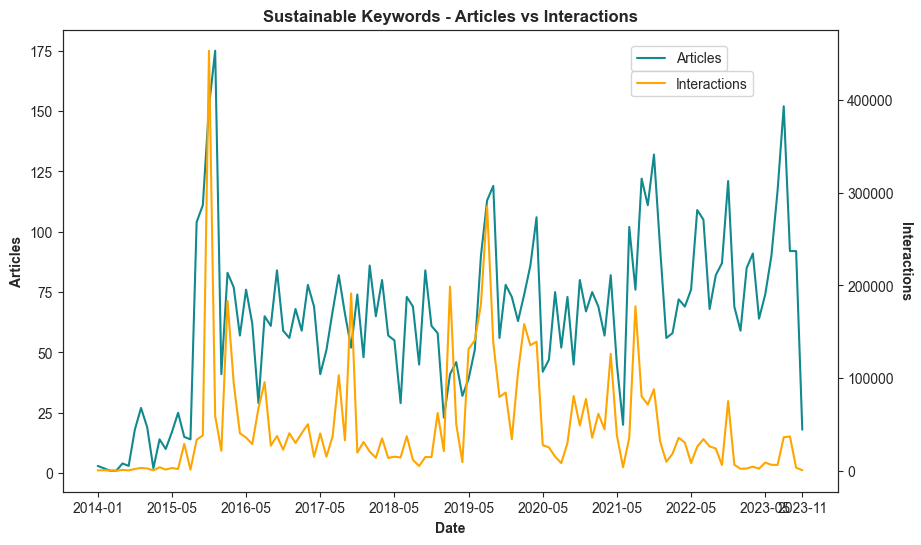

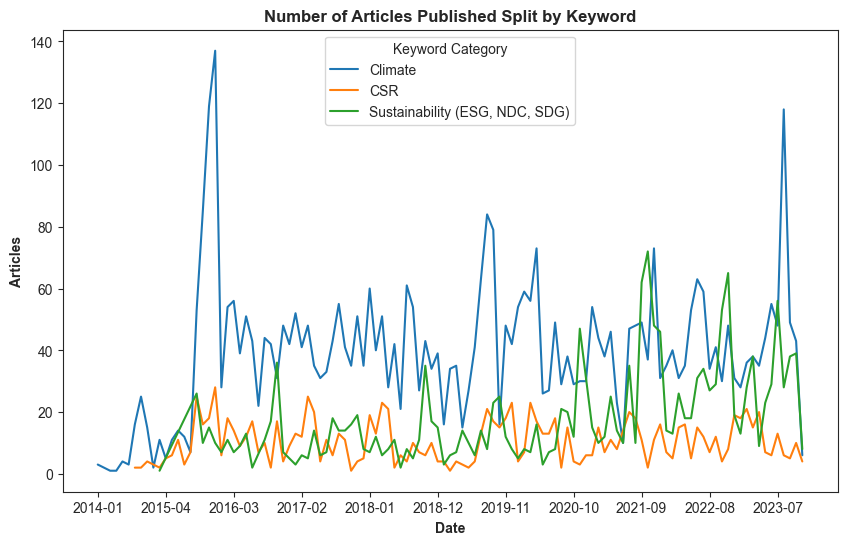

In [33]:
#INTERACTIONS AND ARTICLES PUBLISHED PER MONTH FOR THESE KEYWORDS: CSR, CLIMATE CHANGE, ESG, GLOBAL WARMING, GREENHOUSE GAS, NDC, POLLUTION, SDG

#Import data
mon_2014 = pd.read_excel("Source_Data/Monthly_KW/2014.xlsx",header=0)
mon_2015 = pd.read_excel("Source_Data/Monthly_KW/2015.xlsx",header=0)
mon_2016 = pd.read_excel("Source_Data/Monthly_KW/2016.xlsx",header=0)
mon_2017 = pd.read_excel("Source_Data/Monthly_KW/2017.xlsx",header=0)
mon_2018 = pd.read_excel("Source_Data/Monthly_KW/2018.xlsx",header=0)
mon_2019 = pd.read_excel("Source_Data/Monthly_KW/2019.xlsx",header=0)
mon_2020 = pd.read_excel("Source_Data/Monthly_KW/2020.xlsx",header=0)
mon_2021 = pd.read_excel("Source_Data/Monthly_KW/2021.xlsx",header=0)
mon_2022 = pd.read_excel("Source_Data/Monthly_KW/2022.xlsx",header=0)
mon_2023 = pd.read_excel("Source_Data/Monthly_KW/2023.xlsx",header=0)

#Concatenates wrangled data
mon_kw = pd.concat([wrangle(mon_2014),wrangle(mon_2015),wrangle(mon_2016),wrangle(mon_2017),wrangle(mon_2018),wrangle(mon_2019),wrangle(mon_2020),wrangle(mon_2021),\
                    wrangle(mon_2022),wrangle(mon_2023)],axis=0,ignore_index=True)

#Runs the categorize function on the keyword column and appends a new column containing the category
mon_kw['Keyword Category'] = mon_kw['Keyword'].apply(kw_categorize)

#Reorder columns
mon_kw = mon_kw.reindex(columns=['Date','Keyword','Keyword Category','Title','Website','Interactions'])


#LINEGRAPH - ARTICLES VS INTERACTIONS FOR ALL KEYWORDS
#Groupby Date, count number of keyword articles, and sums interactions then resets index
forviz = mon_kw[['Date','Keyword','Interactions']].groupby(['Date']).agg({'Keyword':'count','Interactions':'sum'}).rename(columns={'Keyword':'Articles'})
forviz.reset_index(inplace=True)
articles_vs_interactions = dual_lines(forviz,'ticks','Date','Articles','#11898E','Interactions','orange','Sustainable Keywords - Articles vs Interactions')


#LINEGRAPH - NUMBER OF ARTICLES SPLIT BY KEYWORD
#Groupby Date and Keyword Category, counts each, renames the column then resets index
keywordz = mon_kw[['Date','Keyword Category','Title']].groupby(['Date','Keyword Category']).count().rename(columns={'Title':'Articles'})
keywordz.reset_index(inplace=True)

#Sets figure size and style
plt.figure(figsize=(10,6))
sns.set_style('ticks')

#Plots linegraph with Date on the x-axis, Articles on the y-axis, keyword categories distinguished by color, and sets the x ticks to be evenly spaced across all months
sns.lineplot(data=keywordz,x='Date',y='Articles',hue='Keyword Category').set_xticks(forviz['Date'].tolist()[0::11])

#Sets axes labels and title
plt.xlabel('Date',fontweight='bold')
plt.ylabel('Articles',fontweight='bold')
plt.title('Number of Articles Published Split by Keyword',fontweight='demibold')
plt.show()

In [34]:
#REVENUE PER SHARE VS TOTAL ESG SCORE FROM YAHOO FINANCE FOR TOP 50 INDONESIAN FIRMS

#Imports tickers of top 50 largest companies in Indonesia by market cap into a dataframe. '.JK' is appended to each name as this is the format found on Yahoo Finance
df1 = pd.DataFrame({'Tickers':[x+'.JK' for x in\
                    list(pd.read_excel("Source_Data/Indo_50_Biggest_Companies.xlsx",sheet_name="50 Biggest Market Capitalizatio",header=3,nrows=51,usecols=[2])['Code'])[1:]]})

#Returns a tuple of called data for each ticker in df1. Uses multi-threading with 10 simultaneous workers to speed up query
with ThreadPoolExecutor(max_workers=10) as executor:
   results = executor.map(fetch_data_for_ticker,df1['Tickers'])

#Unpacks the tuples into 4 distinct variables and assigns these to the relevant columns in df1
for result in results:
    ticker, current_price, revenue_per_share, total_esg = result
    df1.loc[df1['Tickers'] == ticker,'Current Share Price'] = current_price
    df1.loc[df1['Tickers'] == ticker,'Revenue per Share'] = revenue_per_share
    df1.loc[df1['Tickers'] == ticker,'Total ESG Rating'] = total_esg

In [35]:
#BCA
#Calls revenue pdf extracter function for BCA data and filters all outliers using 1.5 * IQR
BCA = revenue('BCA',revenuepage=2)
BCA = BCA.loc[BCA['Monthly Interest'] <= (BCA['Monthly Interest'].quantile(0.75) + 1.5*(BCA['Monthly Interest'].quantile(0.75) - BCA['Monthly Interest'].quantile(0.25)))].sort_values(by='Date',axis=0,ascending=True,ignore_index=True)

#Fills the year's customer count on December every year pulling numbers manually from BCA's yearly reports
BCA['Customers'] = 0
BCA.loc[len(BCA)] = ['2022-12',0,27900000]
BCA.loc[len(BCA)] = ['2021-12',0,22800000]
BCA.loc[len(BCA)] = ['2020-12',5372763,19471200]
BCA.loc[BCA['Date'] == '2019-12','Customers'] = 17017829
BCA.loc[BCA['Date'] == '2018-12','Customers'] = 14601297
BCA.sort_values(by='Date',axis=0,ascending=True,ignore_index=True,inplace=True)

#Adds empty date columns for all missing dates between 2018 to 2023
for year in ['2018','2019','2020','2021','2022','2023']:
    all_dates = [int(x[5:7]) for x in BCA.loc[BCA['Date'].str.contains(year),'Date'].tolist()]
    missing_dates = [str(x) for x in list(range(1,13,1)) if x not in all_dates]
    missing_dates = ['0'+x if len(x) == 1 else x for x in missing_dates]
    for date in missing_dates:
        BCA.loc[len(BCA)] = [year + '-' + date,0,0]
BCA.sort_values(by='Date',axis=0,ascending=True,ignore_index=True,inplace=True)

#Replaces 0 interest values with 0 to be able to use interpolate (formula for creating missing entries based on the surrounding data)
BCA['Monthly Interest'].replace(0,np.nan,inplace=True)
BCA['Monthly Interest'].interpolate(inplace=True)
BCA['Monthly Interest'] = BCA['Monthly Interest'].astype('int')

#Unifies all months in each year with the customer base value
for year in ['2018','2019','2020','2021','2022','2023']:
    BCA.loc[BCA['Date'].str.contains(year),'Customers'] = BCA.loc[BCA['Date'].str.contains(year),'Customers'].sum()

In [61]:
data_2018 = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2018.xlsx",header=0)
data_2019 = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2019.xlsx",header=0)
data_2020 = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2020.xlsx",header=0)
data_2021 = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2021.xlsx",header=0)
data_2022 = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2022.xlsx",header=0)
data_2023 = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2023.xlsx",header=0)

comp_esg = pd.concat([wrangle(data_2018),wrangle(data_2019),wrangle(data_2020),wrangle(data_2021),wrangle(data_2022),wrangle(data_2023)],axis=0,ignore_index=True)
'''
BCA_articles = comp_esg.loc[comp_esg['Keyword'] == 'BCA',['Date','Title','Interactions']].groupby('Date').agg({'Title':'count','Interactions':'sum'}).rename(columns={'Title':'# of Articles'})
BCA_articles.reset_index(inplace=True)
BCA_rev_articles = BCA[['Date','Monthly Interest']].merge(BCA_articles,how='outer',left_on='Date',right_on='Date',sort=True)
BCA_rev_articles[['# of Articles','Interactions']] = BCA_rev_articles[['# of Articles','Interactions']].interpolate()
BCA_rev_articles.loc[0,'# of Articles'] = 1
BCA_rev_articles.loc[0,'Interactions'] = 0
BCA_rev_articles[['# of Articles','Interactions','Monthly Interest']] = BCA_rev_articles[['# of Articles','Interactions','Monthly Interest']].astype('int')
plot = dual_lines(BCA_rev_articles,'ticks','Date','# of Articles','orange','Monthly Interest','#0B6293',"Number of BCA + ESG/CSR Articles vs BCA Monthly Revenue from Consumers")

plt.figure(figsize=(10,6))
sns.set_style('ticks')
ax1 = sns.barplot(data=BCA,x='Date',y='Customers',width=1,fill=True,color='#42A40B',ec='#42A40B',alpha=0.9)
ax1.ticklabel_format(axis='y',style='plain')
ax1.set_ylim(bottom=10000000,top=30000000)
ax2 = plt.twinx()
ax2 = sns.lineplot(data=BCA_rev_articles,x='Date',y='# of Articles',color='#990A0A')
ax1.set_xticks(BCA['Date'].tolist()[::12] + [BCA['Date'].tolist()[-1]])
ax1.set_xlabel('Date',fontweight='bold')
ax1.set_ylabel('Number of Individual Customers',fontweight='bold')
ax2.set_ylabel('# of Articles',fontweight='bold',rotation=270,labelpad=13)
plt.title('BCA ESG Articles Published vs Yearly Customer Base',fontweight='demibold')
plt.show()
'''

comp_esg['ESG Category'] = comp_esg['Title'].apply(esg_categorize)

all_title_words = pd.DataFrame({'Title Words':[i for x in comp_esg.loc[comp_esg['ESG Category'].isna(),'Title'].str.split().tolist() for i in x]})
dontinclude = ['-','di','|','ke','untuk','dan','bri','bca','telkom','astra','daihatsu','csr','esg','indonesia']
all_title_words = all_title_words.loc[~all_title_words['Title Words'].isin(dontinclude)]


print("Percent of uncategorised ESG titles: " + str(round((comp_esg['ESG Category'].isna().sum() / len(comp_esg['ESG Category']))*100)) + '%')
print("Number of uncategorised ESG titles: " + str(len(comp_esg.loc[comp_esg['ESG Category'].isna()])))
print("Number of categorised ESG titles: " + str(len(comp_esg.loc[~comp_esg['ESG Category'].isna()])))
print("Number of ESG titles: " + str(len(comp_esg)))

comp_esg.loc[(comp_esg['ESG Category'].isna()),['Keyword','Title']]
#all_title_words.value_counts()

Percent of uncategorised ESG titles: 67%
Number of uncategorised ESG titles: 722
Number of categorised ESG titles: 354
Number of ESG titles: 1076


,Keyword,Title
0,Telkom,nr 064 2018 idul adha 1439 h telkomgroup serahkan 942 ekor hewan
1,Telkom,telkom university raih perguruan tinggi terbaik di wmm 2018
2,Telkom,"csr telkom dinilai tepat sasaran, efektif dan berdampak positif"
4,Telkom,program csr telkom dinilai efektif dan berdampak poistif | republika online
5,Telkom,nr 028 2018 kegiatan csr telkom dinilai efektif dan berdampak po
6,Telkom,begini penilaian dpr terhadap gelaran csr telkom selama ini
7,Telkom,telkom dan menneg bumn resmikan gereja bersejarah st. martinus hinga - selular.id
8,Telkom,kegiatan csr telkom dinilai efektif dan berdampak positif - selular.id
9,Telkom,"komisi vi dpr angkat bicara soal csr telkom, begini katanya"
11,Telkom,trans java toll expedition | jakarta globe
